In [1]:
import cv2
import time
import imutils
import copy
import numpy as np
import matplotlib.pyplot as plt
from skimage import img_as_uint
from skimage.filters import roberts
%matplotlib inline

In [2]:
def detect_upper_body(img):
    img_copy = np.copy(img)
    img_copy = cv2.cvtColor(img_copy, cv2.COLOR_RGB2GRAY)
    upper_body_cascade = cv2.CascadeClassifier('descriptors/upper_body.xml')
    rectangles = upper_body_cascade.detectMultiScale(img_copy)
    x, y, w, h = rectangles[0]
    cv2.rectangle(img_copy, (x,y), (x+w,y+h),(0,255,0),2)
    image_cut = img_copy[y:y+h, x:x+w]
    plt.imshow(image_cut, cmap="gray")
    return image_cut

def find_contour(gray):
    gray = cv2.GaussianBlur(gray, (7, 7), 0)
    thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cv2.bitwise_not(thresh, thresh)
    plt.imshow(thresh, cmap="gray")
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    return c

def preprocess(img):
    edges = roberts(img)
    plt.imshow(edges, cmap="gray")
    dilation = cv2.dilate(edges, None, iterations=2)
    plt.imshow(dilation, cmap="gray")
    return edges

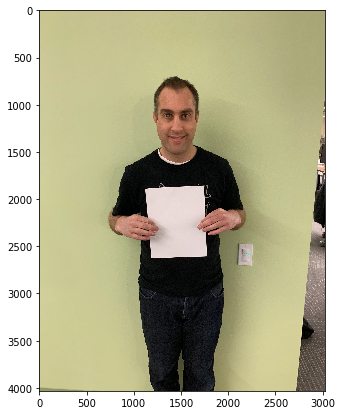

In [3]:
plt.rcParams['figure.figsize'] = [14.0, 7.0]

image = cv2.imread("images/michael.jpg")
image_copy = np.copy(image)
# image_copy = cv2.resize(image_copy, (0,0), fx=0.1, fy=0.1)
image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
plt.imshow(image_copy)

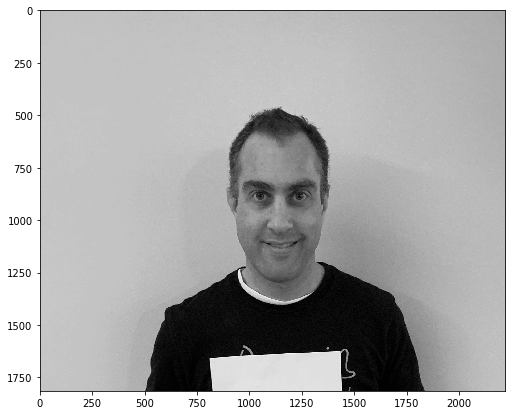

In [4]:
upper_body_image = detect_upper_body(image_copy)

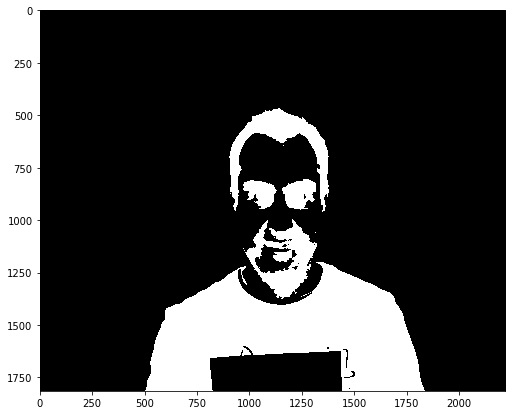

In [5]:
cnt = find_contour(upper_body_image)

In [6]:
leftmost = tuple(cnt[cnt[:,:,0].argmin()][0])
rightmost = tuple(cnt[cnt[:,:,0].argmax()][0])
topmost = tuple(cnt[cnt[:,:,1].argmin()][0])
bottommost = tuple(cnt[cnt[:,:,1].argmax()][0])

left = tuple(cnt[cnt[:, :, 0].argmin()][0])
right = tuple(cnt[cnt[:, :, 0].argmax()][0])
print(f"Left: {leftmost} | Right: {rightmost} | Top: {topmost} | Bottom: {bottommost}")
print(f"Left: {left} | Right: {right}")

Left: (499, 1812) | Right: (1879, 1813) | Top: (1314, 1198) | Bottom: (499, 1813)
Left: (499, 1812) | Right: (1879, 1813)


In [7]:
contour_lines = cv2.drawContours(upper_body_image, [cnt], -1, (204, 255, 0), 3)
contour_lines = cv2.circle(contour_lines, leftmost, 25, (0, 0, 255), -1)
contour_lines = cv2.circle(contour_lines, rightmost, 25, (0, 0, 255), -1)

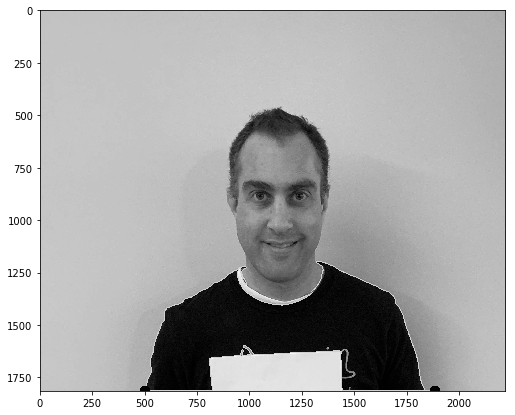

In [8]:
plt.imshow(contour_lines, cmap="gray")

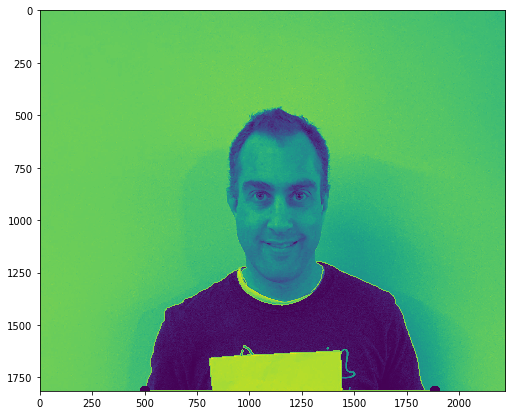

In [9]:
plt.imshow(contour_lines)